# Exploratory Data Analysys

## Exploring the images

In [2]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns

# System 
import sys
sys.path.append('..')
import os

from utils import bboxes
from utils import util_funcs

import importlib
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


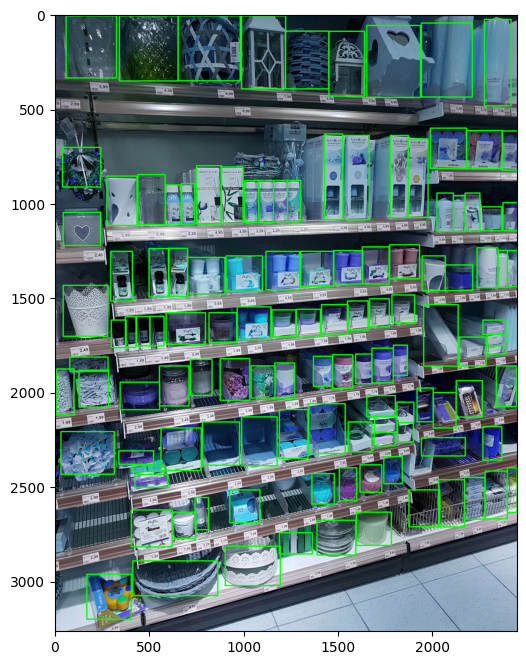

In [4]:
%matplotlib inline
fig,ax = plt.subplots(figsize = (12,8))
img0 = bboxes.get_bboxes('train_150.jpg')

## Failed images

#### Number-of-BBoxes-based analysis

First, we read all annotations in a DataFrame

In [6]:
tags_df = pd.DataFrame()

# Reading in chunks
for chunk_df in util_funcs.read_csv_chunks(chunksize=50000):
    tags_df = pd.concat( [tags_df,chunk_df] , ignore_index = True)

tags_df

img_name    x1    y1    x2    y2    type  height  width
0          train_0.jpg   208   537   422   814  object    3024   3024
1          train_0.jpg  1268  1923  1365  2209  object    3024   3024
2          train_0.jpg  1135  2074  1261  2166  object    3024   3024
3          train_0.jpg  1045  2085  1122  2258  object    3024   3024
4          train_0.jpg   976  2036  1040  2177  object    3024   3024
...                ...   ...   ...   ...   ...     ...     ...    ...
1208477  train_999.jpg   422  2386   675  2542  object    2336   4160
1208478  train_999.jpg   427  2581   667  2715  object    2336   4160
1208479  train_999.jpg   699  2365   823  2474  object    2336   4160
1208480  train_999.jpg  1849  1678  2108  1769  object    2336   4160
1208481  train_999.jpg   905  1589  1144  1712  object    2336   4160

[1208482 rows x 8 columns]

Count the number of 'failed images' i.e. images a lot of missing bounding boxes

In [21]:
# Count images with less that `TAG_THRESH` tags
N_BBOX_THRESH = 60

failed_imgs1 = util_funcs.get_failed_imgs(tags_df, criterion='n_bboxes', thresh= N_BBOX_THRESH, verbose = True)


Number of failed images:  26
List of failed images:
img_name
train_7716.jpg    25
train_7082.jpg    34
train_1172.jpg    37
train_6138.jpg    38
train_7352.jpg    39
train_7584.jpg    40
train_5131.jpg    43
train_104.jpg     44
train_2194.jpg    47
train_5663.jpg    50
train_7487.jpg    50
train_2002.jpg    51
train_6268.jpg    51
train_126.jpg     51
train_3758.jpg    52
train_3530.jpg    53
train_3339.jpg    53
train_7545.jpg    54
train_496.jpg     55
train_6498.jpg    56
train_5815.jpg    56
train_1769.jpg    56
train_7256.jpg    59
train_3874.jpg    59
train_480.jpg     59
train_8016.jpg    59
dtype: int64

This represents 0.0021514594342323676% of the images


We plot some of the 'failed' images to see the missing bboxes

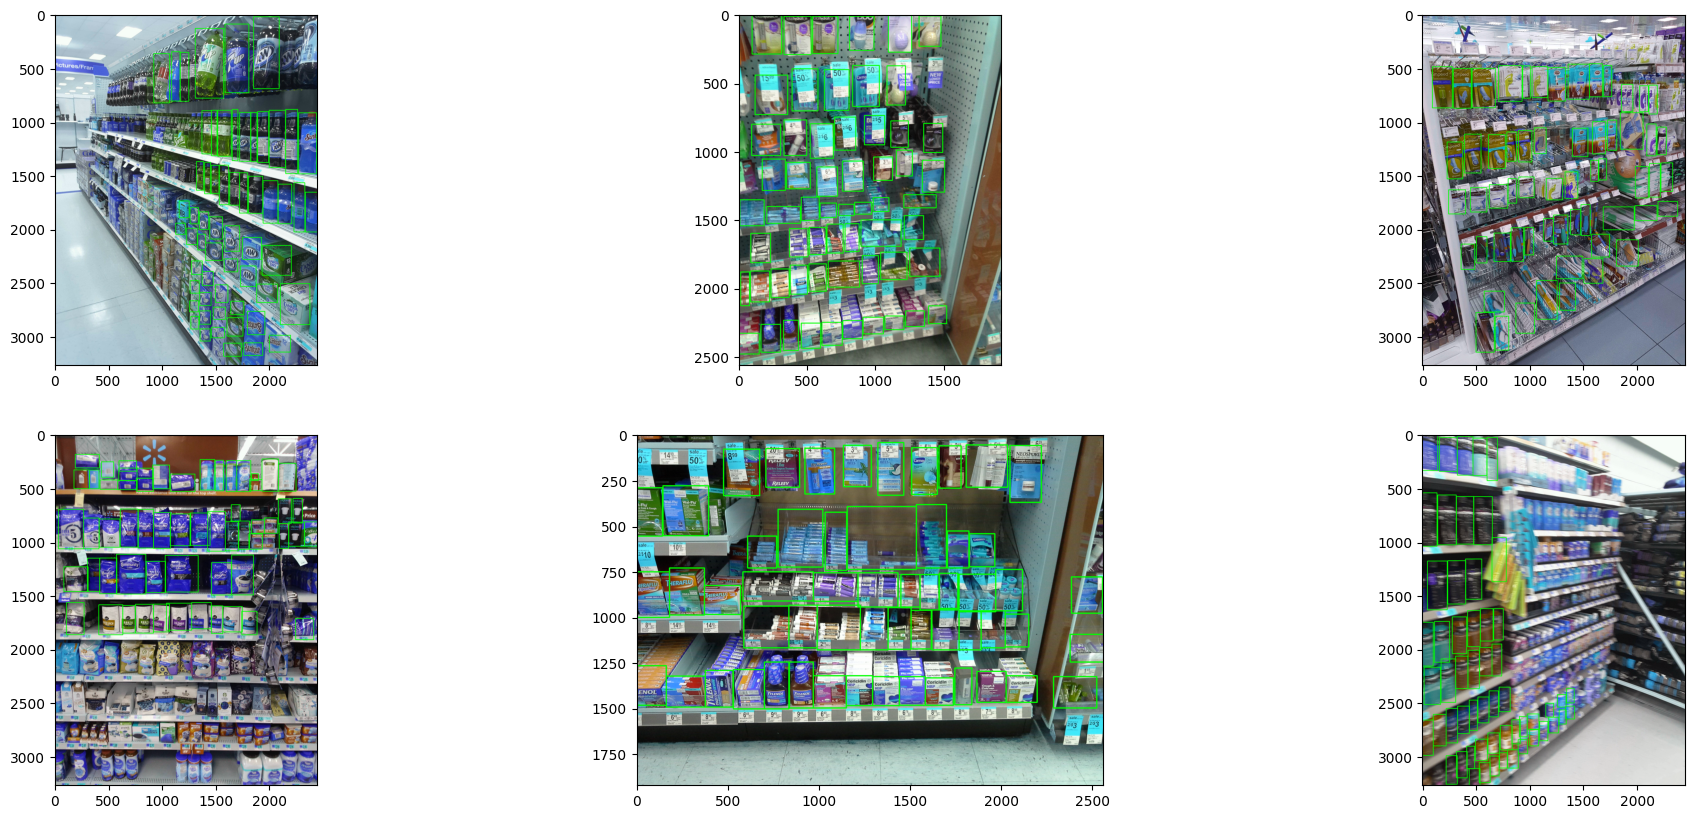

In [22]:

# Number of row and colums in the plot
r = 2 ; c = 3 

def plot_failed_imgs(failed_tags,r,c):
    
    if not len(failed_tags): return None
    _,axis = plt.subplots(r,c,figsize = (25,10))

    for r,ax_list in enumerate(axis):
        for x,ax in enumerate(ax_list):
            idx = x+1+r*c
            _ = bboxes.get_bboxes(img_name= failed_tags.index[-idx], axes= ax)

plot_failed_imgs(failed_imgs1,r,c)    

> _At this point we realized that there could be good images with a low number of bounding boxes._

> **If you observe well, you can notice that 'failed images' are actually to be determined based on the percentage of area that all bounding boxes cover, not on the number of total bounding boxes !!**

> Let's try to use approch to find 'failed images' as images where the bboxes cover a low % of the image

#### Total-Area-based analysis

In [24]:
# Calculate total_area of the images
tags_df['total_area'] = tags_df.height * tags_df.width

# Calculate area of bboxes in the images
tags_df['bbox_area'] = tags_df.apply(lambda r: bboxes.get_bbox_area( (r.x1,r.y1,r.x2,r.y2) ), axis = 1)

# See percentage of area covered by bboxes 
tags_df['bbox_area_perc']  = tags_df.bbox_area / tags_df.total_area

# Get only areas related columns
areas_df = tags_df[['img_name', 'total_area','bbox_area','bbox_area_perc']]
areas_df.set_index('img_name', inplace= True)
areas_df

total_area  bbox_area  bbox_area_perc
img_name                                            
train_0.jpg       9144576      59278        0.006482
train_0.jpg       9144576      27742        0.003034
train_0.jpg       9144576      11592        0.001268
train_0.jpg       9144576      13321        0.001457
train_0.jpg       9144576       9024        0.000987
...                   ...        ...             ...
train_999.jpg     9717760      39468        0.004061
train_999.jpg     9717760      32160        0.003309
train_999.jpg     9717760      13516        0.001391
train_999.jpg     9717760      23569        0.002425
train_999.jpg     9717760      29397        0.003025

[1208482 rows x 3 columns]

We get the % of area covered by the bounding boxes

In [25]:
bbox_area_cover = areas_df.groupby('img_name').bbox_area_perc.sum().sort_values()
bbox_area_cover

img_name
train_3029.jpg    0.006115
train_6566.jpg    0.025378
train_3622.jpg    0.049998
train_6216.jpg    0.053780
train_693.jpg     0.054528
                    ...   
train_7130.jpg    0.736432
train_3456.jpg    0.739458
train_6117.jpg    0.746425
train_5101.jpg    0.747696
train_1557.jpg    0.757186
Name: bbox_area_perc, Length: 8219, dtype: float64

[Text(0.5, 0, '% bbox area')]

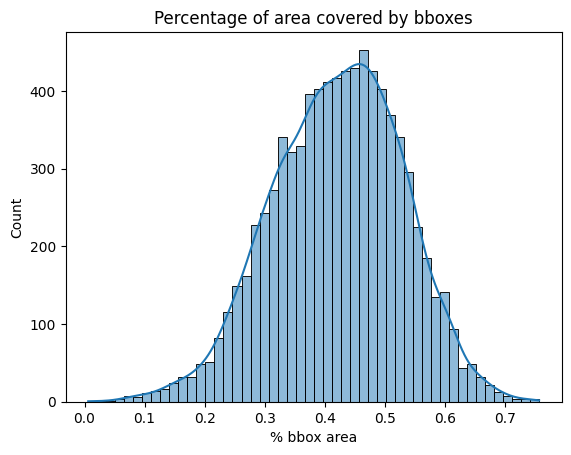

In [26]:
import seaborn as sns

ax = sns.histplot(bbox_area_cover, kde = True )
ax.set_title('Percentage of area covered by bboxes')
_ = ax.set(xlabel = '% bbox area')

We defined the threshold as a quantile from the histogram above, for which we will be consider that the tagging has failed i.e. the minimum area that the bboxes have to cover in order to be considered as a valid tagged image for training

In [34]:
quantile = 0.01
failed_tags_area = util_funcs.get_failed_imgs(tags_df, criterion = 'area', thresh = quantile)
failed_tags_area

Treshold used: 0.15426383982923236
# failed images:  83


img_name
train_3029.jpg    0.006115
train_6566.jpg    0.025378
train_3622.jpg    0.049998
train_6216.jpg    0.053780
train_693.jpg     0.054528
                    ...   
train_2961.jpg    0.152320
train_4101.jpg    0.152860
train_1296.jpg    0.153243
train_6752.jpg    0.153723
train_7164.jpg    0.154225
Name: bbox_area_perc, Length: 83, dtype: float64

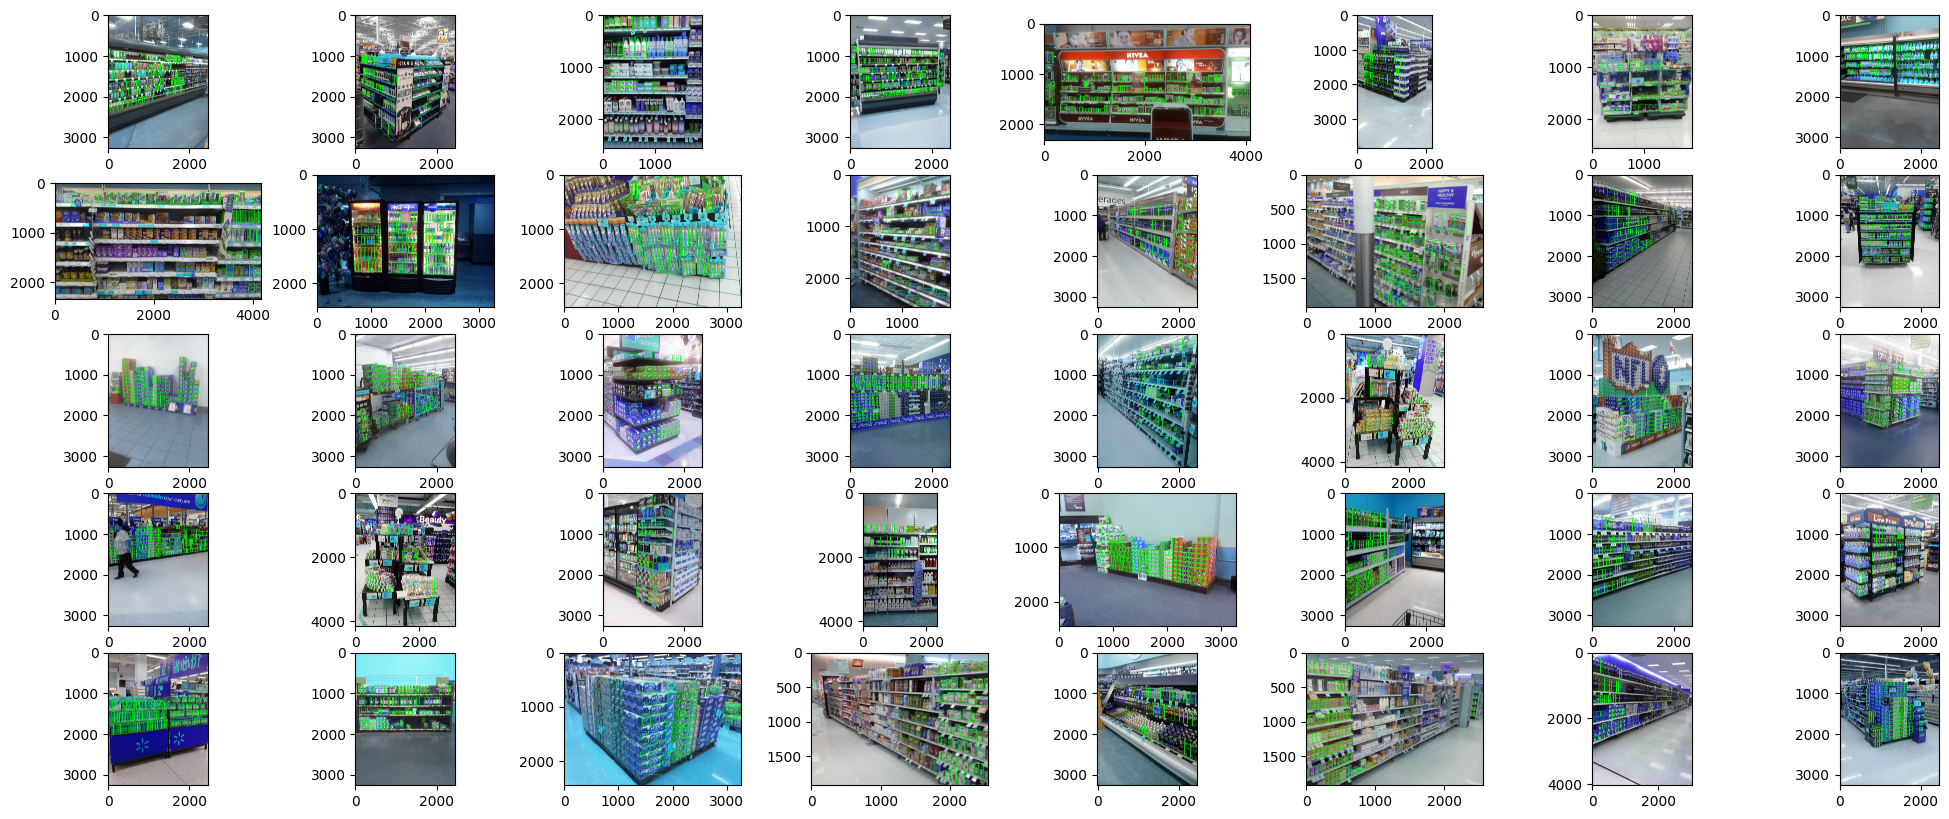

In [35]:
plot_failed_imgs(failed_tags_area,5,8)

> _We are going to directly discard these images from the dataset (some of them have really uggly view angles, some of them have only a few products tagged, etc). We implemented this in the `utils.remove_failed_imgs_from_data` function_

In [36]:
failed_path = os.path.join( util_funcs.IMG_PATH, 'failed_imgs.csv')
failed_tags_area.to_csv(failed_path)

### Corrupted images